In [184]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Dense, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.preprocessing.sequence import pad_sequences
import librosa
from keras.layers import Embedding
from keras.layers import LSTM
from tensorflow.keras.layers import LeakyReLU


In [126]:
class Model(object):
    def __init__(self):
        self.path = '../hidden/protocol_V2/'
        input_shape = (9,)
        self.model = Sequential(self._build_layers())
        self.model.compile(optimizer=RMSprop(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
        self.model.summary()
        self.model_checkpoint = ModelCheckpoint('../hidden/syn_best_model.h5', monitor='val_loss', mode='min', save_best_only=True)


    def load_data(self):
        train_path = os.listdir('../hidden/ASVspoof2017_V2_train/')
        valid_path = os.listdir('../hidden/ASVspoof2017_V2_dev/')
        test_path = os.listdir('../hidden/ASVspoof2017_V2_eval/')

        return train_path, valid_path, test_path

    
    def _load_label(self):
        ground_truth = os.listdir('../hidden/protocol_V2/')
        
        return ground_truth[0], ground_truth[1], ground_truth[2]
    

    def create_dataframe(self):
        valid_gt, test_gt, train_gt = self._load_label()
        train_df = pd.read_csv(self.path + train_gt, sep=' ', names=['filename', 'label', 'M', 'System', 'environment', 'playback','recording device'])
        valid_df = pd.read_csv(self.path + valid_gt, sep=' ', names=['filename', 'label', 'M', 'System', 'environment', 'playback', 'recording device'])
        test_df = pd.read_csv(self.path + test_gt, sep=' ', names=['filename', 'label', 'M', 'System', 'environment', 'playback', 'recording device'])

        train_df['label'] = train_df['label'].replace('genuine', 0)
        train_df['label'] = train_df['label'].replace('spoof', 1)
        
        valid_df['label'] = valid_df['label'].replace('genuine', 0)
        valid_df['label'] = valid_df['label'].replace('spoof', 1)
        
        test_df['label'] = test_df['label'].replace('genuine', 0)
        test_df['label'] = test_df['label'].replace('spoof', 1)
        
        return train_df, valid_df, test_df

    
    def _build_layers(self):
        layers = [
            Dense(units=64, input_shape=(9,), activation='relu'),
            Dense(units=128, activation='relu'),
            Dense(units=192, activation=LeakyReLU(0.15)),
            Dense(units=256, activation=LeakyReLU(0.15)),
            Dense(units=192, activation=LeakyReLU(0.15)),
            Dense(units=128, activation=LeakyReLU(0.15)),
            Dense(units=64, activation=LeakyReLU(0.15)),
            Dense(units=1, activation='sigmoid')]
        return layers


    def fit(self, mfccs, train_labels, n_epoch, n_batch, prefix):
        history = self.model.fit(mfccs, train_labels, n_batch, n_epoch)
        self.model.save(prefix+'.h5')
        return history
    
    
    def evaluate(self, valid_lpcs, valid_labels):
        return self.model.evaluate(valid_lpcs, valid_labels, verbose=1)

In [127]:
M = Model()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_93 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_94 (Dense)             (None, 192)               24768     
_________________________________________________________________
dense_95 (Dense)             (None, 256)               49408     
_________________________________________________________________
dense_96 (Dense)             (None, 192)               49344     
_________________________________________________________________
dense_97 (Dense)             (None, 128)               24704     
_________________________________________________________________
dense_98 (Dense)             (None, 64)              

# LPC (Linear Predictive Coding)

In [5]:
train_path, valid_path, test_path = M.load_data()
train_df, valid_df, test_df = M.create_dataframe()

train_labels = train_df['label']
train_lpcs = list()
for i in range(len(train_path)):
    if i % 300 == 0:
        print (f'[*] {train_path[i]}')
    train_y, train_sr = librosa.load('../hidden/ASVspoof2017_V2_train/' + train_path[i], mono=True)
    train_result = librosa.lpc(train_y, 8)
    train_lpcs.append(train_result)

train_lpcs = np.array(train_lpcs)
print ('[-] Finished')


[*] T_1000001.wav
[*] T_1000302.wav
[*] T_1000602.wav
[*] T_1000902.wav
[*] T_1001202.wav
[*] T_1001502.wav
[*] T_1001803.wav
[*] T_1002103.wav
[*] T_1002403.wav
[*] T_1002703.wav
[*] T_1003003.wav
[-] Finished


In [ ]:
n_epoch = 30

In [324]:
his = M.fit(train_lpcs, train_labels, n_epoch, 32, "lpc")

Epoch 1/30
95/95 [==============================] - 1s 8ms/step - loss: 0.6747 - accuracy: 0.5000
Epoch 2/30
95/95 [==============================] - 1s 7ms/step - loss: 0.6646 - accuracy: 0.5000
Epoch 3/30
95/95 [==============================] - 1s 7ms/step - loss: 0.6564 - accuracy: 0.5003
Epoch 4/30
95/95 [==============================] - 1s 7ms/step - loss: 0.6444 - accuracy: 0.5010
Epoch 5/30
95/95 [==============================] - 1s 7ms/step - loss: 0.6300 - accuracy: 0.5216
Epoch 6/30
95/95 [==============================] - 1s 7ms/step - loss: 0.6127 - accuracy: 0.6254
Epoch 7/30
95/95 [==============================] - 1s 7ms/step - loss: 0.5901 - accuracy: 0.7359
Epoch 8/30
95/95 [==============================] - 1s 7ms/step - loss: 0.5632 - accuracy: 0.8162
Epoch 9/30
95/95 [==============================] - 1s 8ms/step - loss: 0.5335 - accuracy: 0.8673
Epoch 10/30
95/95 [==============================] - 1s 7ms/step - loss: 0.4932 - accuracy: 0.8882
Epoch 11/30
95/95 [

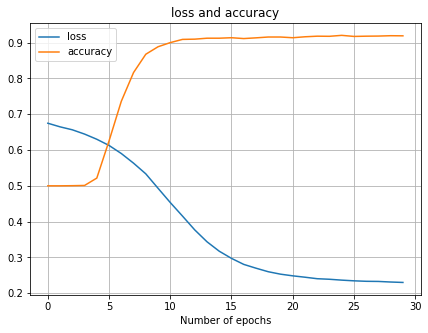

In [327]:
loss = his.history['loss']
accuracy = his.history['accuracy']

plt.figure(figsize=(7,5))
plt.plot(range(n_epoch), loss)
plt.plot(range(n_epoch), accuracy)
plt.xlabel('Number of epochs')
plt.ylabel('')
plt.title('loss and accuracy')
plt.grid(True)
plt.legend(['loss', 'accuracy'])
plt.savefig('lpc_.png')

# LSTM + DNN 모델 설계

In [312]:
def get_lstm_model():
    model = Sequential()
    model.add(LSTM(64, activation='tanh', input_shape=(1, 9), return_sequences=True))
    model.add(LSTM(128, activation='tanh',return_sequences=True))
    model.add(LSTM(128, activation='tanh',return_sequences=True))
    model.add(LSTM(256, activation='tanh',return_sequences=True))
    model.add(LSTM(512, activation='tanh',return_sequences=True))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=RMSprop(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [313]:
lstm_model = get_lstm_model()

## 피처 shape 확인

In [314]:
print (train_lpcs.shape)
print (train_labels.shape)

(3014, 9)
(3014,)


## 피처 reshape

In [315]:
train_lpcs_reshaped = train_lpcs.reshape(-1, 1, 9)
train_labels = np.array(train_labels)
train_labels_reshaped = train_labels.reshape(-1, 1, 1)

print (train_lpcs_reshaped.shape)
print (train_labels_reshaped.shape)

(3014, 1, 9)
(3014, 1, 1)


## LSTM+DNN 모델 학습

In [316]:
lstm_his = lstm_model.fit(train_lpcs_reshaped, train_labels_reshaped, n_epoch, 32, "lpc")

Epoch 1/32
Epoch 2/32
Epoch 3/32
Epoch 4/32
Epoch 5/32
Epoch 6/32
Epoch 7/32
Epoch 8/32
Epoch 9/32
Epoch 10/32
Epoch 11/32
Epoch 12/32
Epoch 13/32
Epoch 14/32
Epoch 15/32
Epoch 16/32
Epoch 17/32
Epoch 18/32
Epoch 19/32
Epoch 20/32
Epoch 21/32
Epoch 22/32
Epoch 23/32
Epoch 24/32
Epoch 25/32
Epoch 26/32
Epoch 27/32
Epoch 28/32
Epoch 29/32
Epoch 30/32
Epoch 31/32
Epoch 32/32


## LSTM+DNN 모델 시각화

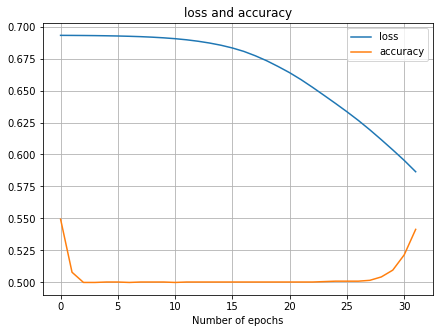

In [305]:
loss = lstm_his.history['loss']
accuracy = lstm_his.history['accuracy']

plt.figure(figsize=(7,5))
plt.plot(range(32), loss)
plt.plot(range(32), accuracy)
plt.xlabel('Number of epochs')
plt.ylabel('')
plt.title('loss and accuracy')
plt.grid(True)
plt.legend(['loss', 'accuracy'])
plt.savefig('lstm.png')

# MFCC (Mel Frequency Capstral Coefficient)

In [110]:

mfccs = list()
for i in range(len(train_path)):
    if i % 300 == 0:
        print (f'[*] {train_path[i]}')
    train_y, train_sr = librosa.load('../hidden/ASVspoof2017_V2_train/' + train_path[i], mono=True)
    D = np.abs(librosa.stft(train_y, n_fft=512, win_length = 512, hop_length=1024))
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(D), y=train_y, sr=train_sr, n_mfcc=20)
    mfcc = pad_sequences(mfcc, maxlen=60, dtype='float', padding='post', truncating='post')
    mfccs.append(mfcc)
mfccs = np.array(mfccs)

[*] T_1000001.wav
[*] T_1000302.wav
[*] T_1000602.wav
[*] T_1000902.wav
[*] T_1001202.wav
[*] T_1001502.wav
[*] T_1001803.wav
[*] T_1002103.wav
[*] T_1002403.wav
[*] T_1002703.wav
[*] T_1003003.wav


In [120]:
mfcc_history = M.fit(mfccs, train_labels, n_epoch, 32, "mfcc")

Epoch 1/30
95/95 [==============================] - 2s 12ms/step - loss: 1.2714 - accuracy: 0.5069
Epoch 2/30
95/95 [==============================] - 1s 12ms/step - loss: 1.1356 - accuracy: 0.5097
Epoch 3/30
95/95 [==============================] - 1s 12ms/step - loss: 1.0711 - accuracy: 0.5138
Epoch 4/30
95/95 [==============================] - 1s 12ms/step - loss: 1.0146 - accuracy: 0.5145
Epoch 5/30
95/95 [==============================] - 1s 12ms/step - loss: 0.9662 - accuracy: 0.5150
Epoch 6/30
95/95 [==============================] - 1s 12ms/step - loss: 0.9374 - accuracy: 0.5175
Epoch 7/30
95/95 [==============================] - 1s 12ms/step - loss: 0.9035 - accuracy: 0.5176
Epoch 8/30
95/95 [==============================] - 1s 12ms/step - loss: 0.8849 - accuracy: 0.5212
Epoch 9/30
95/95 [==============================] - 1s 12ms/step - loss: 0.8554 - accuracy: 0.5223
Epoch 10/30
95/95 [==============================] - 1s 12ms/step - loss: 0.8441 - accuracy: 0.5246
Epoch 11/

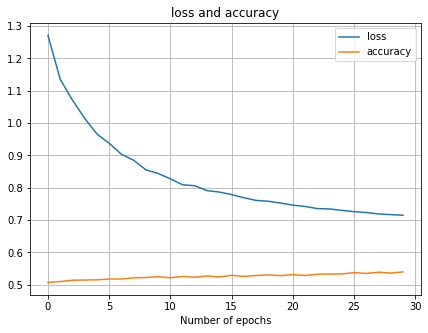

In [121]:
loss = mfcc_history.history['loss']
accuracy = mfcc_history.history['accuracy']

plt.figure(figsize=(7,5))
plt.plot(range(n_epoch), loss)
plt.plot(range(n_epoch), accuracy)
plt.xlabel('Number of epochs')
plt.ylabel('')
plt.title('loss and accuracy')
plt.grid(True)
plt.legend(['loss', 'accuracy'])
plt.savefig('mfcc.png')

# Mel Spectogram

In [58]:


melspecs = list()
for i in range(len(train_path)):
    if i % 500 == 0:
        print (f'[*] {train_path[i]}')
    train_y, train_sr = librosa.load('../hidden/ASVspoof2017_V2_train/' + train_path[i], mono=True)
    D = np.abs(librosa.stft(train_y))**2
    #D = np.abs(librosa.stft(train_y, n_fft=512, win_length = 512, hop_length=1024))
    S = librosa.feature.melspectrogram(y=train_y, sr=train_sr)
    X = pad_sequences(S, maxlen=120, dtype='float', padding='post', truncating='post')
    melspecs.append(X)
    
melspecs = np.array(melspecs)


[*] T_1000001.wav
[*] T_1000502.wav
[*] T_1001002.wav
[*] T_1001502.wav
[*] T_1002003.wav
[*] T_1002503.wav
[*] T_1003003.wav


In [125]:
melspecs_history = M.fit(melspecs, train_labels, n_epoch, 32, "melspectrogram")

Epoch 1/30
95/95 [==============================] - 2s 14ms/step - loss: 0.7952 - accuracy: 0.5369
Epoch 2/30
95/95 [==============================] - 1s 14ms/step - loss: 0.7631 - accuracy: 0.5485
Epoch 3/30
95/95 [==============================] - 1s 13ms/step - loss: 0.7482 - accuracy: 0.5545
Epoch 4/30
95/95 [==============================] - 1s 14ms/step - loss: 0.7395 - accuracy: 0.5578
Epoch 5/30
95/95 [==============================] - 1s 13ms/step - loss: 0.7310 - accuracy: 0.5598
Epoch 6/30
95/95 [==============================] - 1s 13ms/step - loss: 0.7273 - accuracy: 0.5616
Epoch 7/30
95/95 [==============================] - 1s 13ms/step - loss: 0.7224 - accuracy: 0.5624
Epoch 8/30
95/95 [==============================] - 1s 13ms/step - loss: 0.7202 - accuracy: 0.5636
Epoch 9/30
95/95 [==============================] - 1s 13ms/step - loss: 0.7154 - accuracy: 0.5651
Epoch 10/30
95/95 [==============================] - 1s 13ms/step - loss: 0.7127 - accuracy: 0.5632
Epoch 11/

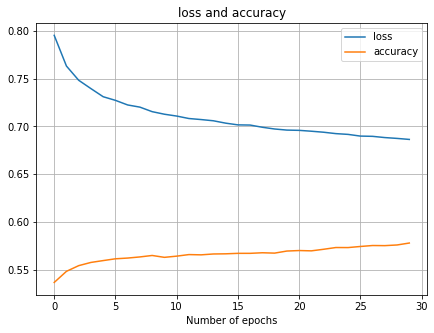

In [126]:
loss = melspecs_history.history['loss']
accuracy = melspecs_history.history['accuracy']

plt.figure(figsize=(7,5))
plt.plot(range(n_epoch), loss)
plt.plot(range(n_epoch), accuracy)
plt.xlabel('Number of epochs')
plt.ylabel('')
plt.title('loss and accuracy')
plt.grid(True)
plt.legend(['loss', 'accuracy'])
plt.savefig('melspectro.png')

In [87]:

chroma_cqs = list()
for i in range(len(train_path)):
    if i % 300 == 0:
        print (f'[*] {train_path[i]}')
    train_y, train_sr = librosa.load('../hidden/ASVspoof2017_V2_train/' + train_path[i], mono=True)
    chroma_stft = librosa.feature.chroma_stft(y=train_y, sr=train_sr, n_chroma=12, n_fft=2048)
    chroma_cq = librosa.feature.chroma_cqt(y=train_y, sr=train_sr)
    X = pad_sequences(chroma_cq, maxlen=120, dtype='float', padding='post', truncating='post')
    chroma_cqs.append(X)
    
chroma_cqs = np.array(chroma_cqs)

[*] T_1000001.wav
[*] T_1000302.wav
[*] T_1000602.wav
[*] T_1000902.wav
[*] T_1001202.wav
[*] T_1001502.wav
[*] T_1001803.wav
[*] T_1002103.wav
[*] T_1002403.wav
[*] T_1002703.wav
[*] T_1003003.wav


In [98]:
chroma_cq = M.fit(chroma_cqs, train_labels, n_epoch, 32, "chroma_cq")

Epoch 1/30
95/95 [==============================] - 2s 12ms/step - loss: 0.6898 - accuracy: 0.5002
Epoch 2/30
95/95 [==============================] - 1s 12ms/step - loss: 0.6865 - accuracy: 0.5009
Epoch 3/30
95/95 [==============================] - 1s 11ms/step - loss: 0.6830 - accuracy: 0.5051
Epoch 4/30
95/95 [==============================] - 1s 12ms/step - loss: 0.6792 - accuracy: 0.5255
Epoch 5/30
95/95 [==============================] - 1s 11ms/step - loss: 0.6754 - accuracy: 0.5536
Epoch 6/30
95/95 [==============================] - 1s 12ms/step - loss: 0.6715 - accuracy: 0.5798
Epoch 7/30
95/95 [==============================] - 1s 12ms/step - loss: 0.6672 - accuracy: 0.6052
Epoch 8/30
95/95 [==============================] - 1s 12ms/step - loss: 0.6638 - accuracy: 0.6139
Epoch 9/30
95/95 [==============================] - 1s 12ms/step - loss: 0.6601 - accuracy: 0.6221
Epoch 10/30
95/95 [==============================] - 1s 11ms/step - loss: 0.6565 - accuracy: 0.6329
Epoch 11/

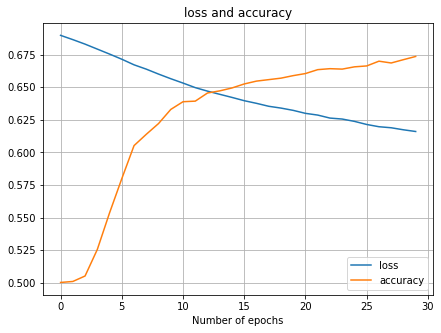

In [99]:
loss = chroma_cq.history['loss']
accuracy = chroma_cq.history['accuracy']

plt.figure(figsize=(7,5))
plt.plot(range(n_epoch), loss)
plt.plot(range(n_epoch), accuracy)
plt.xlabel('Number of epochs')
plt.ylabel('')
plt.title('loss and accuracy')
plt.grid(True)
plt.legend(['loss', 'accuracy'])
plt.savefig('chroma_cq.png')